Pratyush Singh - Lab 4

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

plt.rcParams["figure.figsize"] = (20,15)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data.shape

(4, 25920001)

The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. <br>

## 1A-B
Since our desired observable is the counts, we will plot all the other variables against the counts in order to do some exploratory data analysis. We will plot the counts itself first, to see what it looks like and then make a 2D histogram plotting it against the others.

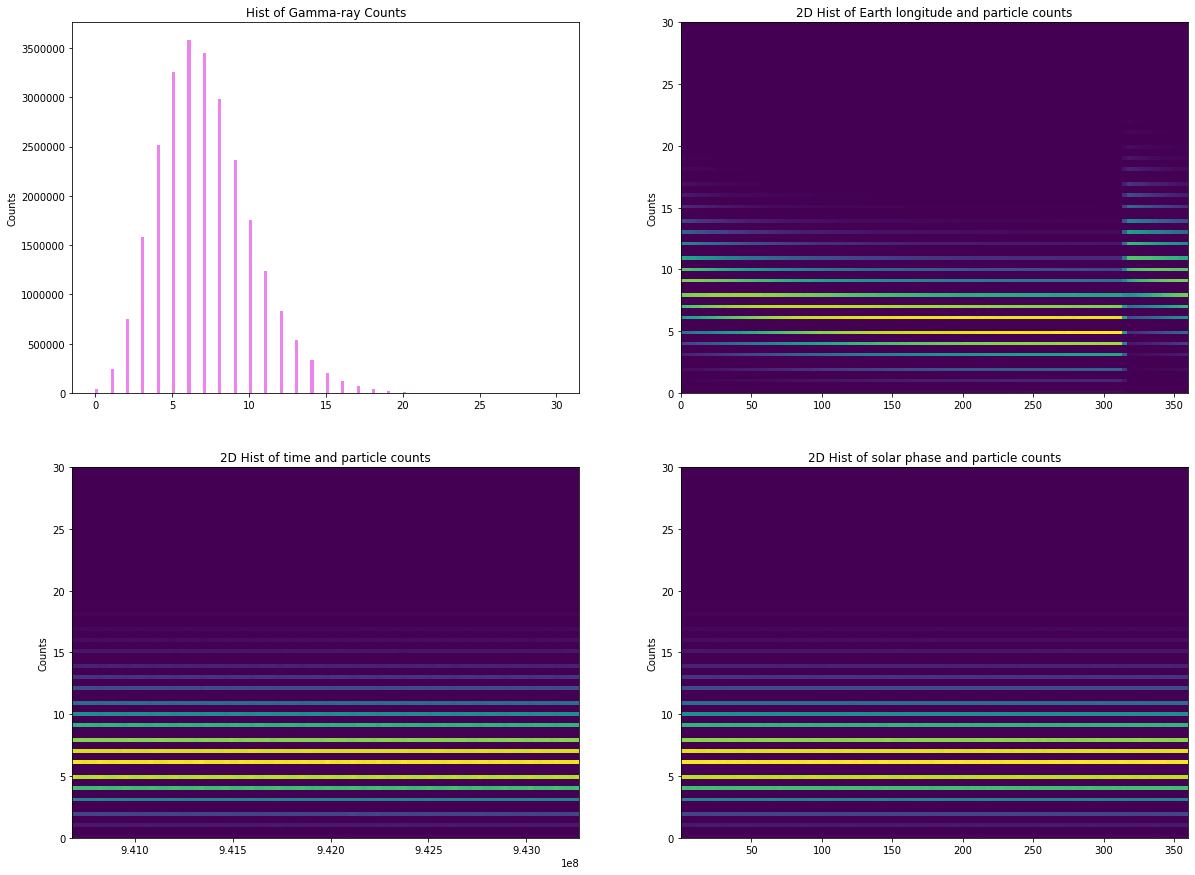

In [6]:
time = data[0,:]
p_counts = data[3,:]
fig, ax = plt.subplots(2,2,figsize=(20, 15))

ax[0,0].hist(p_counts, bins=150, color='violet')
ax[0,0].set_title("Hist of Gamma-ray Counts")
ax[0,0].set_ylabel("Counts")

ax[0,1].hist2d(data[2,:],p_counts, bins=[100,100])
ax[0,1].set_title("2D Hist of Earth longitude and particle counts")
ax[0,1].set_ylabel("Counts")

ax[1,0].hist2d(data[0,:],p_counts,bins=[100,100])
ax[1,0].set_title("2D Hist of time and particle counts")
ax[1,0].set_ylabel("Counts")

ax[1,1].hist2d(data[1,:],p_counts,bins=[100,100])
ax[1,1].set_title("2D Hist of solar phase and particle counts")
ax[1,1].set_ylabel("Counts")

plt.show()

We can see that distributions of counts is a Poisson distribution with an average around 7. On the other plots, we see flat lines when the variable is plotted against the counts which indicates independence. However, on the Earth longitude plot, we see that the plot is not flat which indicates there is some dependence on the Earth phase.

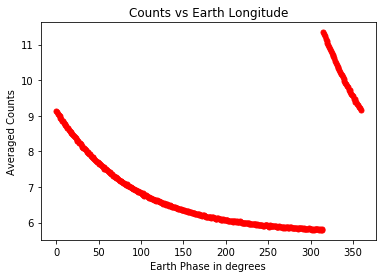

In [7]:
plt.cla()

M = np.max(data[2,])
m = np.min(data[2,])
bins = 360
width = (M - m) / bins
avgs = []

for i in range(bins):
    splrt = np.where((data[2,] > (width * i)) & (data[2,] <= (width * (i +1))))
    s = np.sum(data[3,splrt])
    av = s / len(data[3,splrt][0])
    avgs.append(av)
plt.title("Counts vs Earth Longitude")
plt.ylabel("Averaged Counts")
plt.xlabel("Earth Phase in degrees")    
plt.plot(range(bins),avgs,'or', markersize=5);
plt.rcParams["figure.figsize"] = (10,15)
plt.show()

We can see that average counts change with the phase and that there is a very clear discontinuity at around 315 degrees. The average after that is much higher than before and decreases rapidly.

## 1C
To make a model that is time dependent, we really want a model that recognizes that the counts are in reality phase dependent. As such the model will take Earth phase as a parameter. We can use the average counts per phase array constructed above to find the average of the Poisson distribution for any given integer phase, which then completely determines the distribution. We pick several random values of phase and graph the data against the presumed Poisson distribution to see the quality of the fit.

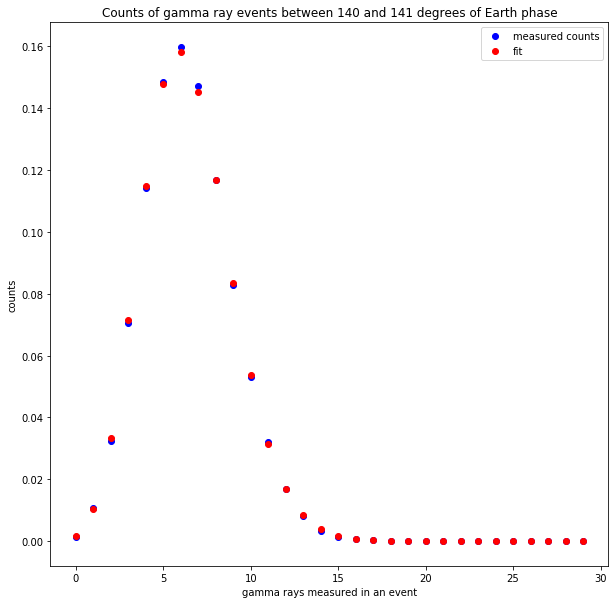

In [10]:
phases = data[2,]
events = data[3,]
Maxy = max(events)
countz = np.zeros(int(Maxy))

plt.figure(figsize=(10,10))
ph = 140

idx = np.where((phases > ph) & (phases <= ph + 1))
ev1 = events[idx]
for n in ev1:
    countz[int(n)] += 1
    
s = sum(countz)
plt.plot(range(30), countz / s, 'bo', label='measured counts')
plt.plot(range(30), stats.poisson.pmf(range(30), avgs[ph]), 'ro', label='fit')
plt.title('Counts of gamma ray events between 140 and 141 degrees of Earth phase')
plt.xlabel('gamma rays measured in an event')
plt.ylabel('counts')
plt.legend()

plt.show()

It looks like the fit agrees with our plot fairly well, we can even plot the value around ~345 degrees from earlier and still expect reasonable agreeableness.

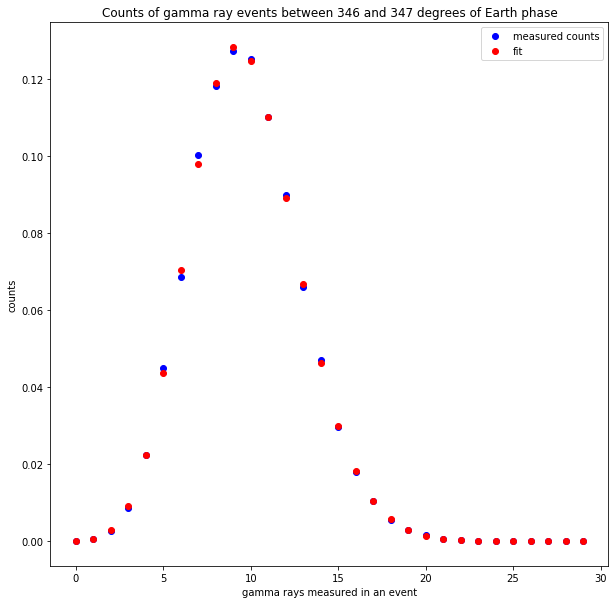

In [13]:
phases = data[2,]
events = data[3,]
Maxy = max(events)
countz = np.zeros(int(Maxy))

plt.figure(figsize=(10,10))
ph = 346

idx = np.where((phases > ph) & (phases <= ph + 1))
ev1 = events[idx]
for n in ev1:
    countz[int(n)] += 1
    
s = sum(countz)
plt.plot(range(30), countz / s, 'bo', label='measured counts')
plt.plot(range(30), stats.poisson.pmf(range(30), avgs[ph]), 'ro', label='fit')
plt.title('Counts of gamma ray events between 346 and 347 degrees of Earth phase')
plt.xlabel('gamma rays measured in an event')
plt.ylabel('counts')
plt.legend()

plt.show()

There is still a decent match, even at this section where we know that there is a drift from the earlier part.

## 1D
100 ms measurement is a single measurement, and we are asking what the 5-sigma threshhold is at various times. We saw from previous sections that the true dependence lies on the earth phase. As such, we need only look at the threshhold for various values of Earth phase. We define the probability of an event here to be the likelihood that the background produces an event that is as or more signal like than our given event, so that a 5-sigma event is an event that has a probability corresponding to an event 5-sigma from the norm in a normal distribution. We lastly need to note our signals are gamma ray bursts, that is, a larger than normal number of gamma rays, so that more gamma rays are more signal like. The probability of an event is then found by just integrating from it to infinity.

In [14]:
sig = stats.norm.cdf(5) # 5 sigma
print('Phase range: 140 to 141')
thresh = stats.poisson.ppf(sig, avgs[140])
print('We find a threshhold of {} gamma rays'.format(thresh))
print('\nPhase range 3: 346 to 347')
thresh2 = stats.poisson.ppf(sig, avgs[346])
print('We find a threshhold of {} gamma rays'.format(thresh2))

Phase range: 140 to 141
We find a threshhold of 23.0 gamma rays

Phase range 3: 346 to 347
We find a threshhold of 29.0 gamma rays


## 2A
First we will open the file and explore it in order to create a background for the faintest stars

In [17]:
h6 = h5py.File('images.h5', 'r')
print(h6.keys())
pics = np.array(h6.get('imagestack'))
print(pics.shape)
print(pics[:,:1])

<KeysViewHDF5 ['image1', 'imagestack']>
(200, 200, 10)
[[[-0.50492093  0.24975188 -0.50405229 ... -0.06210173  1.19841096
   -0.5545422 ]]

 [[-0.25288444  0.40016073 -0.30428969 ... -0.44263445  1.03162128
    0.09690978]]

 [[ 0.82669501 -1.09598848 -1.15713748 ... -0.00567957 -0.50960113
   -0.33764902]]

 ...

 [[-0.04421337  0.71172605  0.68466424 ... -0.73497945 -1.59382711
   -0.33156028]]

 [[ 0.1371078  -0.19467198 -0.54434798 ...  0.52399453  1.34490658
    0.08185939]]

 [[-0.63545846 -0.4667434  -0.44597592 ... -1.0740504  -0.67879436
   -0.06260216]]]


This is a stack of 10 square images, each 200 pixels on a side. We can plot all 10 square images to see how the differ and change.

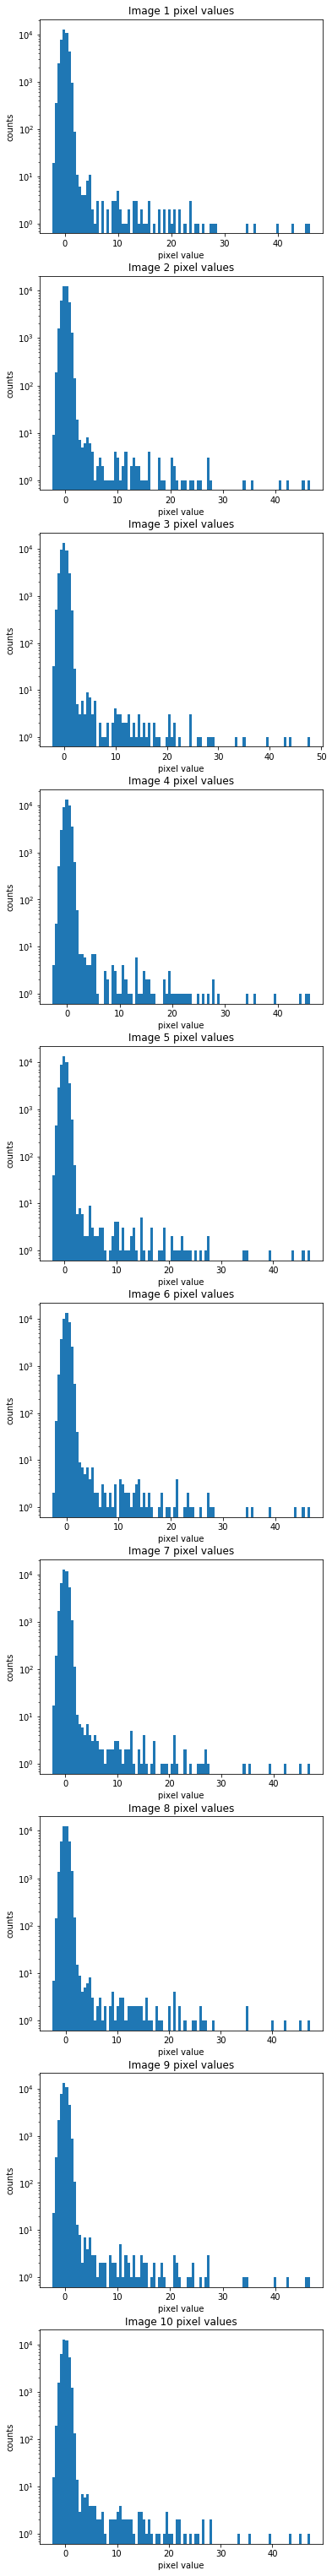

In [22]:

fig, ax = plt.subplots(10, 1, figsize=(6, 55))

for i in range(10):
    lid = np.array([])
    for j in range(200):
        lid = np.concatenate((lid, pics[:,j,i]))
    ax[i].hist(lid, bins=100)
    ax[i].set_yscale('log')
    ax[i].set_title('Image {} pixel values'.format(str(i +1)))
    ax[i].set_xlabel('pixel value')
    ax[i].set_ylabel('counts')

plt.show()

## 2BC
From the plots it appears that each image has 2 parts. There is a normal disribution centered at 0 and is similar across images, along with a tail of bright events. For the faintest of stars, we expect that there not much change between each image so a pixel difference would not be very helpful. Therefore, we need to check against the background to see if there is anything there. We can find the background by using the average of all 10 images. An even then would be measurements on a single pixel across the 10 images.

Unfortunetly I didn't have enough time to find my actual background due complications with the file size and my laptops processing power limited my trial and error approach in the previous sections and I had to wait until the weekend when I had access to a pc back at home.

## 2D
Even though we both are using the same data, we are still looking at different features of the data. While my task concerns finding faint stars, my partner's task is centered on finding bright events that occurs in one image. The pdfs will differ as we are looking for different signals from the data, which requires some customization to remove the background.